In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mlx.core as mx

import sys
sys.path.append('../')
from plotting import radial_plot_power_spectrum

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

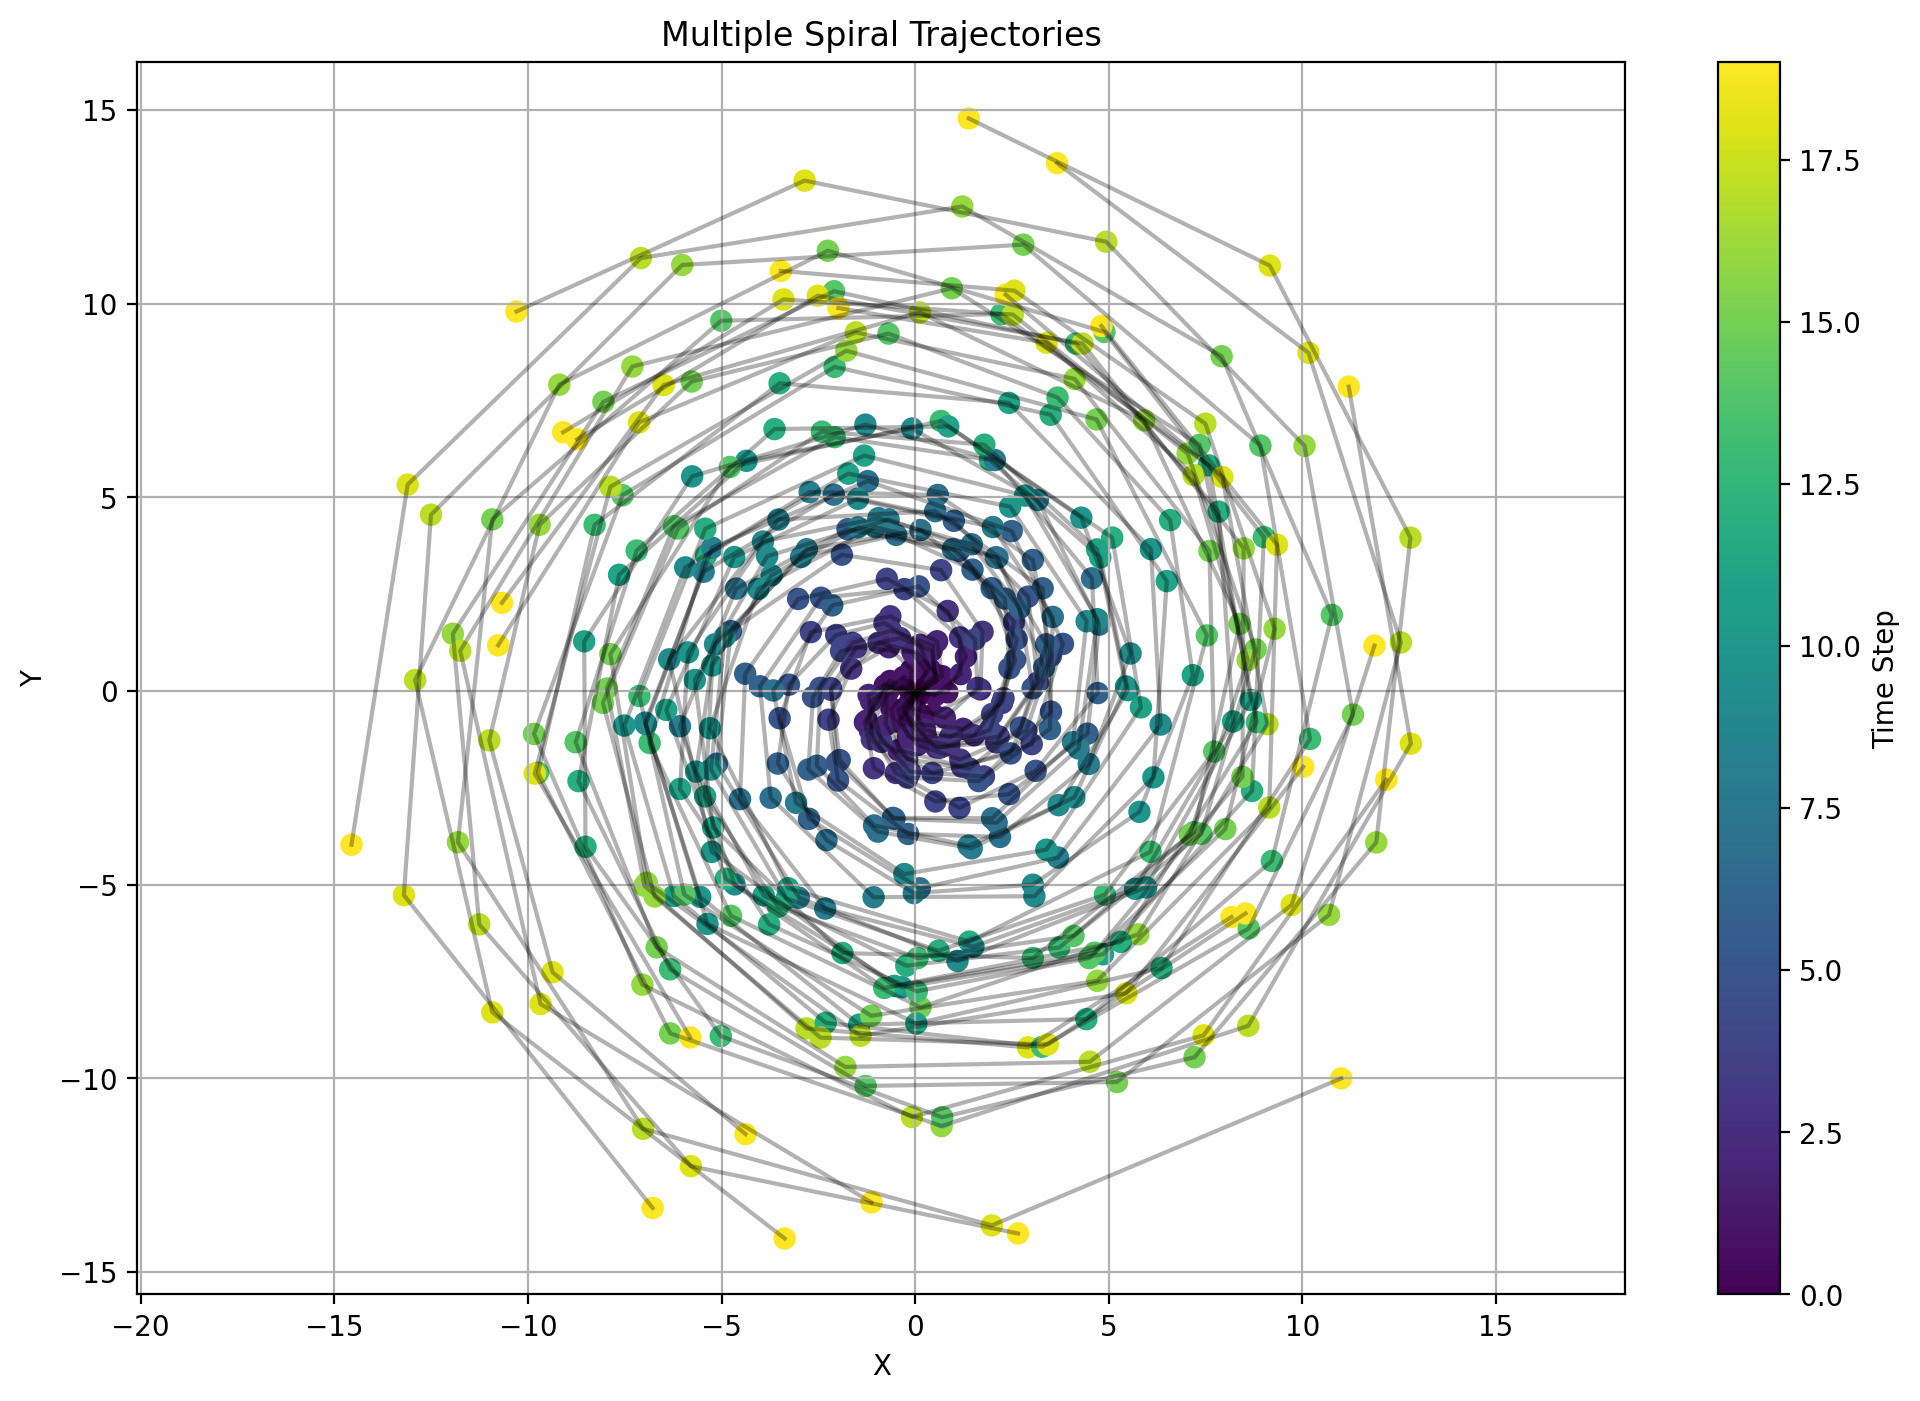

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral_dataset(n_samples=1000, sequence_length=20, noise_level=0.1):
    """
    Generates spiral trajectories dataset.
    Returns: Array of shape (n_samples, 2, sequence_length)
    """
    # Time points
    t = np.linspace(0, 4*np.pi, sequence_length)
    
    # Generate base spiral
    def create_spiral(t, freq=1.0, radius=1.0, phase=0.0):
        x = radius * t * np.cos(freq * t + phase)
        y = radius * t * np.sin(freq * t + phase)
        return np.stack([x, y])
    
    # Generate multiple trajectories
    trajectories = []
    for _ in range(n_samples):
        # Randomize spiral parameters
        freq = np.random.uniform(0.8, 1.2)
        radius = np.random.uniform(0.8, 1.2)
        phase = np.random.uniform(0, 2*np.pi)
        
        # Create trajectory
        traj = create_spiral(t, freq, radius, phase)
        
        # Add noise
        noise = noise_level * np.random.randn(*traj.shape)
        traj += noise
        
        trajectories.append(traj)
    
    return np.array(trajectories)  # Shape: (n_samples, 2, sequence_length)

def plot_multiple_trajectories(n_samples=5, sequence_length=20, noise_level=0.1):
    # Generate data
    data = generate_spiral_dataset(n_samples, sequence_length, noise_level)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each trajectory with color gradient for time
    for i in range(n_samples):
        points = ax.scatter(data[i, 0], data[i, 1], 
                           c=range(sequence_length),
                           cmap='viridis',
                           s=50)
        ax.plot(data[i, 0], data[i, 1], 'k-', alpha=0.3)
    
    plt.colorbar(points, label='Time Step')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')
    ax.set_title('Multiple Spiral Trajectories')
    ax.grid(True)
    return plt.gcf()

# Generate and plot
plot_multiple_trajectories(n_samples=25)
plt.show()

In [176]:
import scipy.io as sio
import h5py as h5
# read mat file with h5py
with h5.File('../data/.data/NavierStokes_V1e-3_N5000_T50.mat', "r") as data:
    a = data["a"][:].transpose(2, 1, 0)
    u = data["u"][:].transpose(3, 1, 2, 0)
    t = data["t"][:].transpose(1, 0)
a.shape, u.shape, t.shape

((5000, 64, 64), (5000, 64, 64, 50), (1, 50))

In [179]:
# save 8 samples of the data as new mat
N = 8
sio.savemat(f'../data/.data/NavierStokes_V1e-3_N{N}_T50.mat', 
                {'a': a[:N], 'u': u[:N], 't': t[:N]}
            )

In [3]:
trial = '00003-cfm-ns'
data = mx.load(os.path.join('../results', trial, 'generated.npz'))
a, u, o = data['a'], data['u'], data['o']

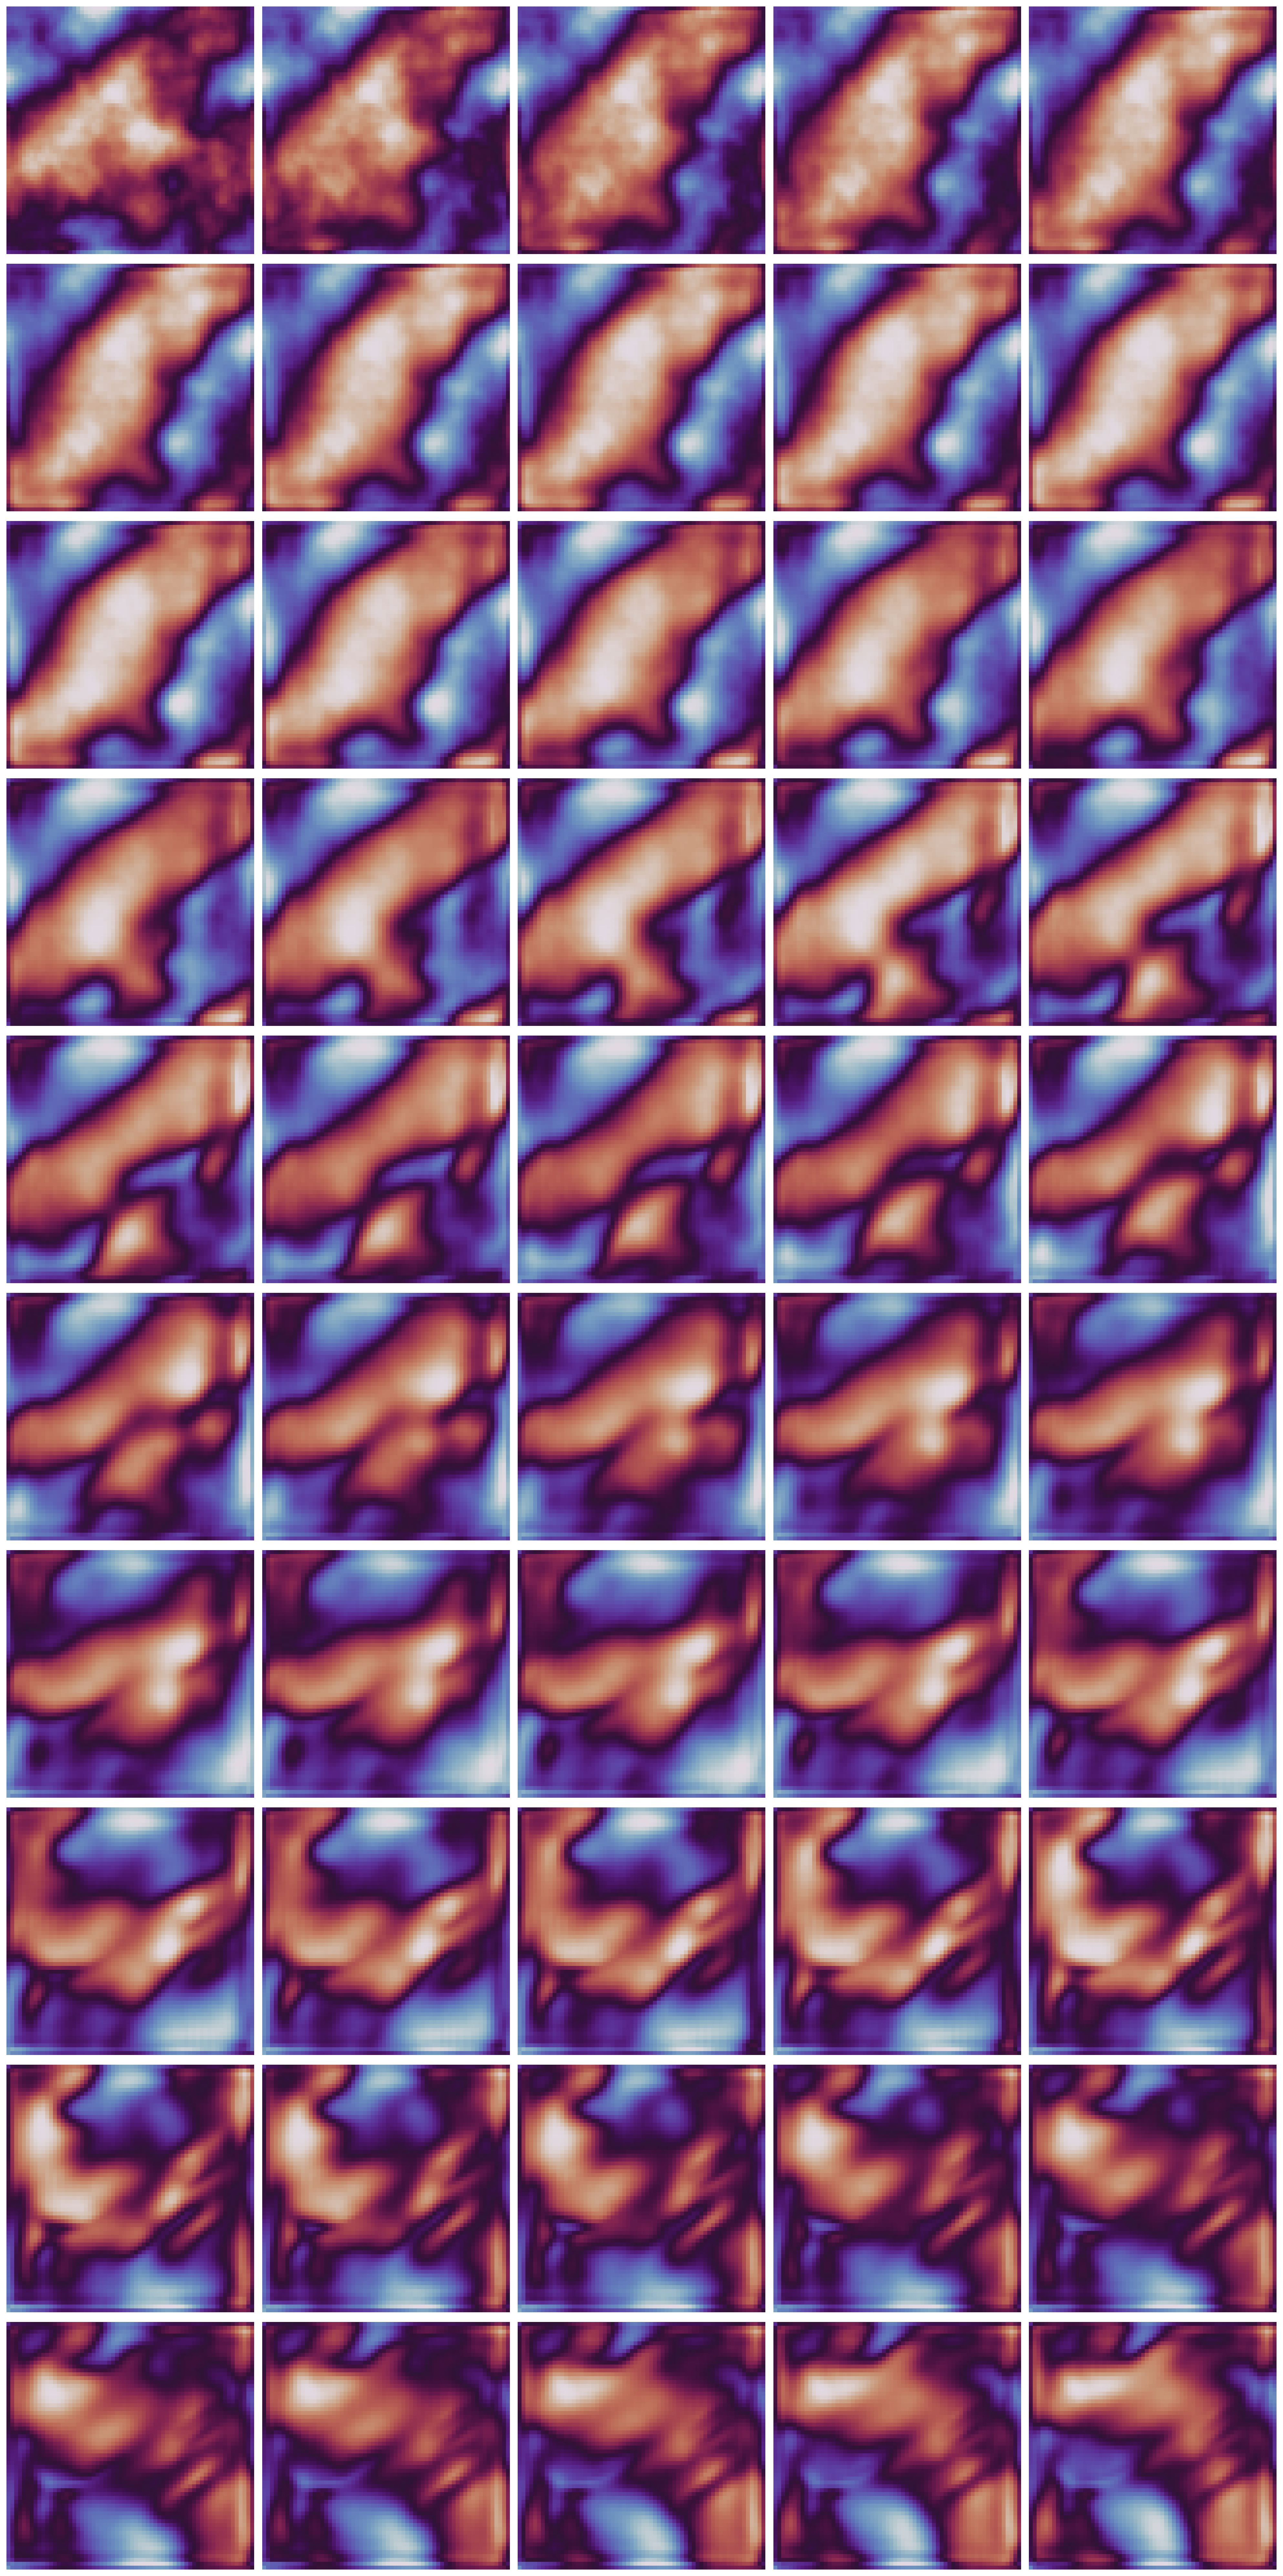

In [5]:
# plot 20 steps of the data
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
for i, ax in enumerate(axs.flat):
    ax.imshow(o[4, ..., i], cmap='twilight')
    ax.axis('off')

plt.tight_layout()

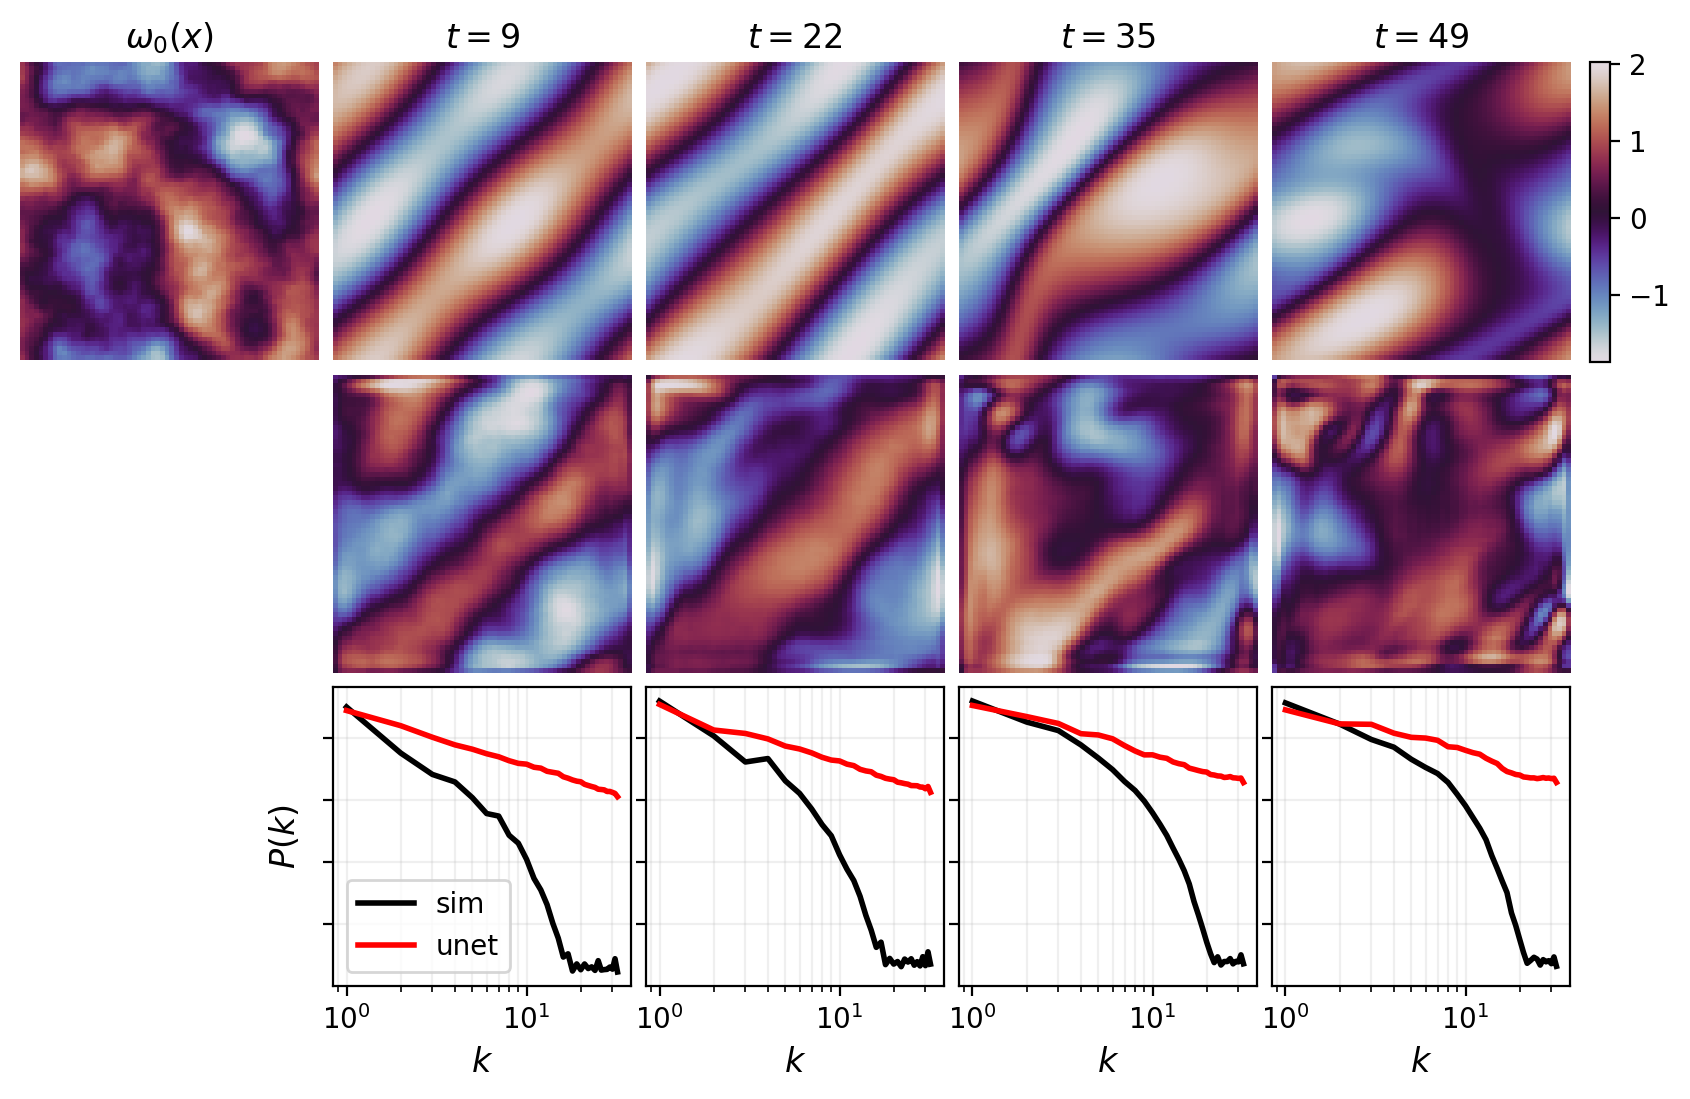

In [13]:
def create_comparison_plots(u, o, a, i=0):
    N, steps = 3, 4
    
    # Create figure with GridSpec for more control
    fig = plt.figure(figsize=(2.5 * steps, 2 * N))
    gs = gridspec.GridSpec(N, steps + 1, figure=fig)
    gs.update(wspace=0.05, hspace=0.05)
    
    # Calculate time indices
    start = int(0.2 * (u.shape[-1] - 1))
    time_indices = mx.linspace(start, u.shape[-1] - 1, num=steps, dtype=mx.int8)
    
    # Create axes with proper spacing
    axes = [[plt.subplot(gs[i, j]) for j in range(steps + 1)] for i in range(N)]
    
    # Plot initial condition
    axes[0][0].imshow(a[i], cmap='twilight')
    axes[0][0].set_title(r"$\omega_0(x)$", pad=5, fontsize=12)
    axes[0][0].axis('off')
    
    # Share y axis for the last row
    shared_yaxis = None
    
    # Plot evolution
    for j, t in enumerate(time_indices):
        # First row - u field
        im1 = axes[0][j + 1].imshow(u[i, ..., t], cmap='twilight')
        axes[0][j + 1].set_title(f"$t={t}$", pad=5, fontsize=12)
        axes[0][j + 1].axis('off')
        
        # Second row - o field
        im2 = axes[1][j + 1].imshow(o[i, ..., t], cmap='twilight')
        axes[1][j + 1].axis('off')
        
        # Third row - power spectra
        uk, up_k = radial_plot_power_spectrum(u[i, ..., t])
        ok, op_k = radial_plot_power_spectrum(o[i, ..., t])
        
        if shared_yaxis is None:
            shared_yaxis = axes[2][j + 1]
        else:
            axes[2][j + 1].sharey(shared_yaxis)
            
        axes[2][j + 1].loglog(uk, up_k, color="k", lw=2, label='sim' if j == 0 else '')
        axes[2][j + 1].loglog(ok, op_k, color="r", lw=2, label='unet' if j == 0 else '')
        axes[2][j + 1].grid(True, which="both", ls="-", alpha=0.2)
        axes[2][j + 1].set_xlabel("$k$", fontsize=12)
        
        if j == 0:
            axes[2][j + 1].set_ylabel(r"$P(k)$", fontsize=12)
            axes[2][j + 1].legend()
        else:
            axes[2][j + 1].set_yticklabels([])

    
    axes[1][0].remove()
    axes[2][0].remove()
    
    cax = fig.add_axes([0.91, 0.63, 0.01, 0.25])
    plt.colorbar(im1, cax=cax)
    
    return fig, axes

# Usage:
fig, axes = create_comparison_plots(u, o, a, i=7)
plt.show()